# Train on PML dataset

## Random Augmentation

In [1]:
import random
import PIL
import PIL.ImageOps
import PIL.ImageEnhance
import PIL.ImageDraw
import numpy as np
import torch
from PIL import Image

class RandomAugment:
    def __init__(self, n, m):
        self.n = n
        self.m = m      # [0, 30] in fixmatch, deprecated.
        self.augment_list = self.get_augment_list()

    def __call__(self, img):
        ops = random.choices(self.augment_list, k=self.n)
        for op, min_val, max_val in ops:
            val = min_val + float(max_val - min_val)*random.random()
            img = op(img, val)
        cutout_val = random.random() * 0.5
        img = self.Cutout(img, cutout_val)  # for fixmatch
        return img

    def get_augment_list(self):
        l = [
            (self.AutoContrast, 0, 1),
            (self.Brightness, 0.05, 0.95),
            (self.Color, 0.05, 0.95),
            (self.Contrast, 0.05, 0.95),
            (self.Equalize, 0, 1),
            (self.Identity, 0, 1),
            (self.Posterize, 4, 8),
            (self.Rotate, -30, 30),
            (self.Sharpness, 0.05, 0.95),
            (self.ShearX, -0.3, 0.3),
            (self.ShearY, -0.3, 0.3),
            (self.Solarize, 0, 256),
            (self.TranslateX, -0.3, 0.3),
            (self.TranslateY, -0.3, 0.3)
        ]
        return l

    def AutoContrast(self, img, _):
        return PIL.ImageOps.autocontrast(img)

    def Brightness(self, img, v):
        assert v >= 0.0
        return PIL.ImageEnhance.Brightness(img).enhance(v)

    def Color(self, img, v):
        assert v >= 0.0
        return PIL.ImageEnhance.Color(img).enhance(v)

    def Contrast(self, img, v):
        assert v >= 0.0
        return PIL.ImageEnhance.Contrast(img).enhance(v)

    def Equalize(self, img, _):
        return PIL.ImageOps.equalize(img)

    def Invert(self, img, _):
        return PIL.ImageOps.invert(img)

    def Identity(self, img, v):
        return img

    def Posterize(self, img, v):  # [4, 8]
        v = int(v)
        v = max(1, v)
        return PIL.ImageOps.posterize(img, v)

    def Rotate(self, img, v):  # [-30, 30]
        #assert -30 <= v <= 30
        # if random.random() > 0.5:
        #    v = -v
        return img.rotate(v)

    def Sharpness(self, img, v):  # [0.1,1.9]
        assert v >= 0.0
        return PIL.ImageEnhance.Sharpness(img).enhance(v)

    def ShearX(self, img, v):  # [-0.3, 0.3]
        #assert -0.3 <= v <= 0.3
        # if random.random() > 0.5:
        #    v = -v
        return img.transform(img.size, PIL.Image.AFFINE, (1, v, 0, 0, 1, 0))

    def ShearY(self, img, v):  # [-0.3, 0.3]
        #assert -0.3 <= v <= 0.3
        # if random.random() > 0.5:
        #    v = -v
        return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, v, 1, 0))

    def TranslateX(self, img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
        #assert -0.3 <= v <= 0.3
        # if random.random() > 0.5:
        #    v = -v
        v = v * img.size[0]
        return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0))

    def TranslateXabs(self, img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
        #assert v >= 0.0
        # if random.random() > 0.5:
        #    v = -v
        return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0))

    def TranslateY(self, img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
        #assert -0.3 <= v <= 0.3
        # if random.random() > 0.5:
        #    v = -v
        v = v * img.size[1]
        return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v))

    def TranslateYabs(self, img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
        #assert 0 <= v
        # if random.random() > 0.5:
        #    v = -v
        return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v))

    def Solarize(self, img, v):  # [0, 256]
        assert 0 <= v <= 256
        return PIL.ImageOps.solarize(img, v)

    def CutoutAbs(self, img, v):  # [0, 60] => percentage: [0, 0.2]
        # assert 0 <= v <= 20
        if v < 0:
            return img
        w, h = img.size
        x0 = np.random.uniform(w)
        y0 = np.random.uniform(h)

        x0 = int(max(0, x0 - v / 2.))
        y0 = int(max(0, y0 - v / 2.))
        x1 = min(w, x0 + v)
        y1 = min(h, y0 + v)

        xy = (x0, y0, x1, y1)
        color = (125, 123, 114)
        # color = (0, 0, 0)
        img = img.copy()
        PIL.ImageDraw.Draw(img).rectangle(xy, color)
        return img

    def Cutout(self, img, v):  # [0, 60] => percentage: [0, 0.2] => change to [0, 0.5]
        assert 0.0 <= v <= 0.5
        if v <= 0.:
            return img

        v = v * img.size[0]
        return self.CutoutAbs(img, v)

In [2]:
import torchvision.transforms as transforms

def get_transform(img_size=224, name='basic'):
    if name == 'basic':
        t = transforms.Compose([
            transforms.Resize(img_size), 
            transforms.RandomResizedCrop(size=img_size, scale=(0.2, 1.)),
            transforms.ToTensor(), 
            transforms.Normalize((0.2443, 0.2394, 0.2425), (0.2443, 0.2394, 0.2425))
        ])
    
    elif name =='weak':
        t = transforms.Compose([
            transforms.Resize(img_size), 
            transforms.RandomResizedCrop(size=img_size, scale=(0.2, 1.)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([
                transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
            ], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.ToTensor(), 
            transforms.Normalize((0.2443, 0.2394, 0.2425), (0.2443, 0.2394, 0.2425))
        ])
    elif name == 'strong':
        t = transforms.Compose([           
            transforms.Resize(img_size), 
            transforms.RandomResizedCrop(size=img_size, scale=(0.2, 1.)),
            transforms.RandomHorizontalFlip(),
            RandomAugment(n=3, m=5),
            transforms.ToTensor(), 
            transforms.Normalize((0.2443, 0.2394, 0.2425), (0.2443, 0.2394, 0.2425))
        ])
    else:
        raise ValueError("unsupported transform name ‘{}’".format(name))
        
    return t

## Dataset

In [3]:
@torch.no_grad()
def generate_uniform_cv_candidate_labels(train_labels, partial_rate=0.1):
    K = int(torch.max(train_labels) - torch.min(train_labels) + 1)
    n = train_labels.shape[0]

    partialY = torch.zeros(n, K)
    partialY[torch.arange(n), train_labels] = 1.0
    transition_matrix =  np.eye(K)
    transition_matrix[np.where(~np.eye(transition_matrix.shape[0],dtype=bool))] = partial_rate
    # print(transition_matrix)

    random_n = np.random.uniform(0, 1, size=(n, K))

    for j in range(n):  # for each instance
        partialY[j, :] = torch.from_numpy((random_n[j, :] < transition_matrix[train_labels[j], :]) * 1)

    # print("Finish Generating Candidate Label Sets!\n")
    return partialY

In [4]:
import numpy as np

def split_trainval_dataset(dataset, split_ratio=[0.5, 0.5], shuffle=True, seed=None):
    indices = list(range(len(dataset)))
    split_ratio = (np.cumsum([0] + split_ratio) * len(dataset)).astype(int)

    if shuffle:
        if seed is not None:
            np.random.seed(seed)
        np.random.shuffle(indices)
    
    splited_indices = [indices[begin: end] for begin, end in zip(split_ratio[:-1], split_ratio[1:])]
    splited_sampler = [torch.utils.data.SubsetRandomSampler(idxs) for idxs in splited_indices]
    
    return splited_sampler

In [5]:
import torch
import torchvision
from os.path import join

class CocoDataset(torch.utils.data.Dataset):
    def __init__(self, root='/hdd/lzm/dataset/coco/', partial_rate=0.1, img_size=224):
        print("loading dataset ...")
        base_dataset = torchvision.datasets.CocoDetection(
            root=join(root, f'train2017'), 
            annFile=join(root, f'annotations/instances_train2017.json')
        )
        
        # many unlabeled samples are included, filter them out
        targets = [base_dataset._load_target(id) for id in range(len(base_dataset))]
        labels = [sorted(list({seg_box['category_id'] for seg_box in elem})) for elem in targets]
        available_idxs, labels = zip(*[
            (i, lbl) for i, lbl in enumerate(labels) if len(lbl) > 0
        ])
        
        # some label value is not used, re-mapping them (labels -> y_indexs)
        lbl2idx = {lbl: idx for idx, lbl in enumerate(set(sum(labels, [])))}
        y_indexs = [[lbl2idx[lbl] for lbl in elem] for elem in labels]
        
        # generate ground-truth multi-label target (Y_true)
        num_samples, dim_labels = len(labels), len(lbl2idx)
        Y_true = torch.zeros(num_samples, dim_labels, requires_grad=False)
        for row in range(num_samples):
            Y_true[row, y_indexs[row]] = 1

        # generate candidate label set (Y_candidate)
        Y_candidate = Y_true.clone()
        Y_candidate[torch.rand_like(Y_candidate) < partial_rate] = 1
        
        self.base_dataset = base_dataset
        self.available_idxs = available_idxs
        self.Y_true = Y_true
        self.Y_candidate = Y_candidate
        self.dim_labels = dim_labels
        
        self.basic_transform = get_transform(img_size=img_size, name='basic')
        self.weak_transform = get_transform(img_size=img_size, name='weak')
        self.strong_transform = get_transform(img_size=img_size, name='strong')
        
    def _get_mean_and_std(self, images):
        to_tensor = torchvision.transforms.ToTensor()
        mean_, std_ = [], []
        
        for image in images:
            image = to_tensor(image)
            mean_.append(image.mean(dim=[1,2]))
            std_.append(image.std(dim=[1,2]))

        mean_ = torch.vstack(mean_).mean(dim=0)
        std_ = torch.vstack(std_).mean(dim=0)
        return std_, std_
    
    def __len__(self):
        return len(self.available_idxs)
    
    @torch.no_grad()
    def __getitem__(self, index):
        image_index = self.available_idxs[index]
        image = self.base_dataset._load_image(image_index)
        image_basic = self.basic_transform(image)
        image_weak_aug = self.weak_transform(image)
        image_strong_aug = self.strong_transform(image)
        
        y_true = self.Y_true[index, :]
        y_candidate = self.Y_candidate[index, :]
        
        return index, image_basic, image_weak_aug, image_strong_aug, y_true, y_candidate

## Model

In [6]:
from torch import nn
import torchvision
from torch.nn.functional import normalize
import timm

# basic MLP network
class MlpNet(nn.Module):
    def __init__(self, in_features, out_features, hidden_layer_sizes=[]):
        super(MlpNet, self).__init__()
        sizes = [in_features] + list(hidden_layer_sizes) + [out_features]
        
        sequential = []
        sequential.append(torch.nn.Flatten())
        sequential.append(torch.nn.Linear(sizes[0], sizes[1], bias=True))
        for in_, out_ in zip(sizes[1:-1], sizes[2:]):
            sequential.append(torch.nn.ReLU(inplace=True))
            sequential.append(torch.nn.Linear(in_, out_, bias=True))
        # sequential.append(nn.functional.sigmoid())
        
        self.sequential = nn.Sequential(*sequential)
            
    def forward(self, x):
        x = x.to(torch.float32)
        x = self.sequential(x)
        return x

    
class PicoNet(nn.Module):
    def __init__(self, dim_embedding, num_classes, *, pretrained=False):
        super(PicoNet, self).__init__()
        
        encoder, out_dim = torchvision.models.resnet18(pretrained=pretrained), 512
        # encoder, out_dim = timm.create_model('tresnet_l.miil_in1k', pretrained=pretrained), 1000 
        # don't use timm.create_model! it leads to unknown correlated bugs when create two or more model
        encoder.fc = nn.Identity()
        
        self.encoder = encoder
        self.embedding_head = MlpNet(out_dim, dim_embedding, hidden_layer_sizes=[])
        self.classific_head = MlpNet(out_dim, num_classes, hidden_layer_sizes=[out_dim])

    def forward(self, x):
        x = self.encoder(x)
        embedding = normalize(self.embedding_head(x), p=2, dim=1)
        cls_logit = self.classific_head(x)
        return embedding, cls_logit


## Loss

In [7]:
from leemultilearn.metrics import (
    hamming_loss as hamming_loss_numpy, 
    label_ranking_loss as label_ranking_loss_numpy,
    average_precision_score as average_precision_score_numpy
)

In [8]:
@torch.no_grad()
def hamming_loss(y_true, y_pred):
    y_true = y_true.cpu().detach().numpy()
    y_pred = y_pred.cpu().detach().numpy()
    return hamming_loss_numpy(y_true, y_pred)

@torch.no_grad()
def label_ranking_loss(y_true, y_pred_proba):
    y_true = y_true.cpu().detach().numpy()
    y_pred_proba = y_pred_proba.cpu().detach().numpy()
    return label_ranking_loss_numpy(y_true, y_pred_proba)

@torch.no_grad()
def average_precision_score(y_true, y_pred_proba):
    y_true = y_true.cpu().detach().numpy()
    y_pred_proba = y_pred_proba.cpu().detach().numpy()
    return average_precision_score_numpy(y_true, y_pred_proba)

In [60]:
from torch.nn.functional import log_softmax

def info_nce_loss2(query, keys, positive_mask, temperature=0.07):
    # query: (n, d)
    # keys: (m, d)
    # positive_mask: (n, m)
    assert query.shape[1] == keys.shape[1]
    assert query.shape[0] == positive_mask.shape[0]
    assert keys.shape[0] == positive_mask.shape[1]
    assert positive_mask.min() >= 0
    
    logit = query @ keys.t() / temperature # (n, m)
    loss = (-positive_mask * log_softmax(logit, dim=1)).sum(dim=1) / positive_mask.sum(dim=1)
    loss = loss.mean()
    
    return loss

In [10]:
def multilabel_partial_loss(y_target, y_score):
    # y_score = y_score.clip(min=0.01, max=0.99)
    loss = -(y_target * torch.log(y_score + 1e-10) + (1.0 - y_target) * torch.log(1.0 - y_score + 1e-10))
    return loss.sum(dim=1).mean()

In [11]:
class PmlLoss(torch.nn.Module):
    def __init__(self):
        super(PmlLoss, self).__init__()

    def forward(self, y_logit, y_target, weight=None):
        # Calculating Probabilities
        y_score = torch.sigmoid(y_logit)
        y_score_pos = y_score
        y_score_neg = 1 - y_score

        # Basic BCE calculation
        los_pos = y_target * torch.log(y_score_pos)
        los_neg = (1 - y_target) * torch.log(y_score_neg)
        loss = los_pos + los_neg

        if weight != None:
            loss *= weight

        return -loss.sum(dim=1).mean()

In [12]:
y_target = torch.randn((50, 20))
y_target = torch.randn((50, 20))

## Logger

In [13]:
class Meter(object):
    def __init__(self, **kwargs):
        self.reset()
        self.format(**kwargs)

    def reset(self):
        self.fmt = dict()
        self.values = dict()

    def format(self, **kwargs):
        for key, fmt_str in kwargs.items():
            self.fmt[key] = fmt_str

    def average_value(self):
        return {key: sum(vals) / len(vals) for key, vals in self.values.items()}

    def last_value(self):
        return {key:  vals[-1] for key, vals in self.values.items()}

    def update(self, **kwargs):
        for key, val in kwargs.items():
            self._update(key, val)

    def _create(self, key):
        if key not in self.fmt.keys():
            self.fmt[key] = ':5.3f'
        self.values[key] = []

    def _update(self, key, val):
        if key not in self.values.keys():
            self._create(key)
        self.values[key].append(val)

    def _str(self, key, val):
        return ('{key:s}: {val' + self.fmt[key] + '}').format(key=key, val=val)


class AverageMeter(Meter):
    def __init__(self, **kwargs):
        super(AverageMeter, self).__init__()

    def __str__(self):
        return ', '.join([
            self._str(key, val) for key, val in self.average_value().items()
        ])


class LastMeter(Meter):
    def __init__(self, **kwargs):
        super(LastMeter, self).__init__()

    def __str__(self):
        return ', '.join([
            self._str(key, val) for key, val in self.last_value().items()
        ])

## Utils

In [14]:
def sharpen(y_score, *, t=0.5, eps=1e-2):
    # row_sum = y_score.sum(dim=1, keepdim=True)
    y_score = y_score ** (1 / t)
    row_max = y_score.max(dim=1, keepdim=True).values + eps
    row_min = y_score.min(dim=1, keepdim=True).values - eps
    # y_score = row_sum * normalize(y_score, p=1, dim=1)
    y_score = (y_score - row_min) / (row_max - row_min)
    return y_score

In [15]:
from torch.nn.functional import mse_loss

@torch.no_grad()
def pseudo_label_accuracy(Y_cls_target, Y_candidate, Y_true):
    mask = Y_candidate.nonzero()
    y_true = Y_true[mask[:, 0], mask[:, 1]]
    y_score = Y_cls_target[mask[:, 0], mask[:, 1]]
    return (1 - mse_loss(y_score, y_true)).item()

## Train & Eval

In [16]:
from torch import softmax, sigmoid, exp
from torch.nn.functional import normalize, one_hot, log_softmax, mse_loss
from tqdm.notebook import tqdm

### Vanilla

In [17]:
def train_epoch_vanilla(show_progress=False):
    global train_loader, optimizer, model_q, model_k
    global Y_cls_target
    
    meter = AverageMeter()

    model_q.train()
    model_k.train()
    
    for indices, img, img_w, img_s, y_true, y_candidate in tqdm(train_loader, leave=False, disable=not show_progress):
        img_w, img_s = img_w.cuda(), img_s.cuda()
        y_candidate, y_true = y_candidate.cuda(), y_true.cuda()
        indices = indices.cuda()
        batch_size, num_classes = y_candidate.shape

        _, y_logit_q = model_q(img_w)
        _, y_logit_k = model_k(img_w)
        y_score_q = sigmoid(y_logit_q)
        y_score_k = sigmoid(y_logit_k)
        
        loss = multilabel_partial_loss(y_target=Y_cls_target[indices], y_score=y_score_q)
        
        # optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # record
        meter.update(
            loss_clf=loss.item(), 
            r_loss_q=label_ranking_loss(y_true, y_score_q),
            mAP_q=average_precision_score(y_true, y_score_q),
            r_loss_k=label_ranking_loss(y_true, y_score_k),
            mAP_k=average_precision_score(y_true, y_score_k),
        )
        
    with torch.no_grad():
        for param_q, param_k in zip(model_q.parameters(), model_k.parameters()):
            param_k.data += momentum_encoder * (param_q.data - param_k.data)

    return meter

In [18]:
@torch.no_grad()
def eval_epoch_vanilla(show_progress=False):
    global test_loader, model_q, model_k
    
    meter = AverageMeter()
    
    model_q.eval()
    model_k.eval()
    
    for indices, img, img_w, img_s, y_true, y_candidate in tqdm(test_loader, leave=False, disable=not show_progress):
        img = img.cuda()
        y_candidate, y_true = y_candidate.cuda(), y_true.cuda()
        indices = indices.cuda()
        batch_size, num_classes = y_candidate.shape

        _, y_logit_q = model_q(img)
        _, y_logit_k = model_k(img)
        y_score_q = sigmoid(y_logit_q)
        y_score_k = sigmoid(y_logit_k)

        loss = multilabel_partial_loss(y_target=y_true, y_score=y_score_q)

        # record
        meter.update(
            loss_clf=loss.item(), 
            r_loss_q=label_ranking_loss(y_true, y_score_q),
            mAP_q=average_precision_score(y_true, y_score_q),
            r_loss_k=label_ranking_loss(y_true, y_score_k),
            mAP_k=average_precision_score(y_true, y_score_k),
        )


    return meter

### Contrastive

In [55]:
def train_epoch_contrastive(show_progress=False, update_target=False):
    global train_loader, optimizer
    global model_q, model_k
    global Y_cls_target, embed_p_pos, embed_p_neg
    global embed_k_queue, y_target_q_queue, queue_idx, queue_size
    global classific_weight, contrastive_weight
    global momentum_encoder, momentum_proto, momentum_target

    meter = AverageMeter()
    meter.format(
        loss_clf=':5.3f', loss_con=':5.3f', 
        mAP_clf=':5.3f',  mAP_proto=':5.3f', 
    )
    
    model_q.train()
    model_k.train()
    
    for indices, img, img_w, img_s, y_true, y_candidate in tqdm(train_loader, leave=False, disable=not show_progress):
        img_w, img_s = img_w.cuda(), img_s.cuda()
        y_candidate, y_true = y_candidate.cuda(), y_true.cuda()
        indices = indices.cuda()
        batch_size, num_classes = y_candidate.shape

        embed_q, y_logit_q = model_q(img_w)
        embed_k, _         = model_k(img_s) # no_grad
        
        y_score_q = sigmoid(y_logit_q)
        
        y_score_p_pos = 0.5 + 0.5 * embed_q @ embed_p_pos.t() # (0, 1)
        y_score_p_neg = 0.5 + 0.5 * embed_q @ embed_p_neg.t() # (0, 1)
        y_score_p = y_score_p_pos / (y_score_p_pos + y_score_p_neg)

        y_target_q = (y_score_q > 0.5).float().detach() * y_candidate # no_grad
        y_target_p = (y_score_p > 0.5).float().detach() * y_candidate # no_grad
        
        # momentum update
        with torch.no_grad():
            # momentum update embed_p_pos, embed_p_neg
            for tgt, emd_q in zip(y_target_q, embed_q):
                embed_p_pos += momentum_proto * (emd_q.unsqueeze(0) - embed_p_pos) * tgt.unsqueeze(-1)
                embed_p_neg += momentum_proto * (emd_q.unsqueeze(0) - embed_p_neg) * (1.0 - tgt).unsqueeze(-1)
            embed_p_pos = normalize(embed_p_pos, p=2, dim=1)
            embed_p_neg = normalize(embed_p_neg, p=2, dim=1)

            # momentum update Y_cls_target
            if update_target:
                Y_cls_target[indices] += momentum_target * (y_target_p - Y_cls_target[indices])

            # update queue
            embed_k_queue[queue_idx: queue_idx + batch_size] = embed_k
            y_target_q_queue[queue_idx: queue_idx + batch_size] = y_target_q
            queue_idx = (queue_idx + batch_size) % queue_size
        
        # make contrastive pairs
        with torch.no_grad():
            keys = torch.cat([embed_q, embed_k_queue], dim=0)
            targets = torch.cat([y_target_q, y_target_q_queue], dim=0)
            mask = (torch.cdist(y_target_q, targets) < 0.1).float()
            # mask-out self-contrast cases
            mask *= (1.0 - torch.eye(*mask.shape).to(mask.device))
            proto_similarity = ((embed_q @ keys.t()) * mask).sum() / mask.sum()
        
        loss_classific = multilabel_partial_loss(y_target=Y_cls_target[indices], y_score=y_score_q)
        loss_contrastive = info_nce_loss2(query=embed_q, keys=keys, positive_mask=mask)
        # auxiliary loss
        loss_prototype = 0.0
        
        loss = classific_weight * loss_classific + contrastive_weight * loss_contrastive

        # optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # record
        meter.update(
            loss_clf=loss_classific.item(), 
            loss_con=loss_contrastive.item(),
            mAP_clf=average_precision_score(y_true, y_score_q), 
            mAP_proto=average_precision_score(y_true, y_score_p),
            sim_proto=proto_similarity
        )
        
        with torch.no_grad():
            # momentum update encoder_k
            for param_q, param_k in zip(model_q.parameters(), model_k.parameters()):
                param_k.data += momentum_encoder * (param_q.data - param_k.data)

        
    return meter

In [50]:
@torch.no_grad()
def eval_epoch_contrastive(show_progress=False):
    global test_loader
    global model_q, model_k
    global Y_true, Y_candidate, Y_cls_target, embed_p_pos, embed_p_neg
    global embed_k_queue, y_target_q_queue, queue_idx, queue_size
    global contrastive_weight, momentum_encoder, momentum_proto, momentum_target
    
    meter = AverageMeter()
    meter.format(
        conf_pseu=':5.3f', # confidence of pseudo labels
        acc_pseu=':5.3f', # accuracy of pseudo labels
        mAP_clf=':5.3f',  mAP_proto=':5.3f', 
        sim_proto=':5.3f'
    )
    
    model_q.eval()
    model_k.eval()
    
    for indices, img, img_w, img_s, y_true, y_candidate in tqdm(test_loader, leave=False, disable=not show_progress):
        img_w, img_s = img_w.cuda(), img_s.cuda()
        y_candidate, y_true = y_candidate.cuda(), y_true.cuda()
        indices = indices.cuda()
        batch_size, num_classes = y_candidate.shape

        embed_q, y_logit_q = model_q(img_w)
        embed_k, _         = model_k(img_s) # no_grad
        
        y_score_q = sigmoid(y_logit_q)
        y_target_q = (y_score_q > 0.5).float().detach()
        
        y_score_p_pos = 0.5 + 0.5 * embed_q @ embed_p_pos.t()
        y_score_p_neg = 0.5 + 0.5 * embed_q @ embed_p_neg.t()
        y_score_p = y_score_p_pos / (y_score_p_pos + y_score_p_neg)
        
        with torch.no_grad():
            keys = torch.cat([embed_q, embed_k_queue], dim=0)
            targets = torch.cat([y_target_q, y_target_q_queue], dim=0)
            mask = (torch.cdist(y_target_q, targets) < 0.1).float()
            mask *= (1.0 - torch.eye(*mask.shape).to(mask.device))
            proto_similarity = ((embed_q @ keys.t()) * mask).sum() / mask.sum()
        
        # record
        meter.update(
            conf_pseu=Y_cls_target.max(dim=1).values.mean().item(),
            acc_pseu=pseudo_label_accuracy(Y_cls_target, Y_candidate, Y_true),
            mAP_clf=average_precision_score(y_true, y_score_q), 
            mAP_proto=average_precision_score(y_true, y_score_p), 
            sim_proto=proto_similarity
        )

    return meter

## Start

### Initialization

In [21]:
import torch.backends.cudnn as cudnn
import random
import numpy as np

In [22]:
cudnn.benchmark = True
seed = 123
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
cudnn.deterministic = True
# torch.use_deterministic_algorithms(True)

In [23]:
# dataset
dataset = CocoDataset(partial_rate=0.05)
print(f'candidate-labels per sample: {dataset.Y_candidate.sum(dim=1).mean():.2f}')
print(f'true-labels per sample: {dataset.Y_true.sum(dim=1).mean():.2f}')

loading dataset ...
loading annotations into memory...
Done (t=15.71s)
creating index...
index created!
candidate-labels per sample: 6.79
true-labels per sample: 2.94


In [24]:
from torch.utils.data import DataLoader
batch_size = 32

train_sampler, test_sampler = split_trainval_dataset(dataset, split_ratio=[0.2, 0.1], shuffle=True, seed=123)
assert set(train_sampler.indices) & set(test_sampler.indices) == set()
train_loader = DataLoader(
    dataset, 
    batch_size=batch_size, sampler=train_sampler, 
    num_workers=8, drop_last=True
)
test_loader = DataLoader(
    dataset, 
    batch_size=batch_size, sampler=test_sampler, 
    num_workers=8, drop_last=True
)

In [25]:
# models
num_classes = dataset.dim_labels
dim_embedding = 128
model_q = PicoNet(dim_embedding=dim_embedding, num_classes=num_classes, pretrained=True).cuda()
model_k = PicoNet(dim_embedding=dim_embedding, num_classes=num_classes, pretrained=True).cuda()

for param_q, param_k in zip(model_q.parameters(), model_k.parameters()):
    param_k.data.copy_(param_q.data.detach())
    param_k.requires_grad = False
    assert param_q.requires_grad == True

optimizer = torch.optim.SGD(
    params=model_q.parameters(),
    lr=1e-2,
    momentum=0.9,
    weight_decay=1e-4
)

/hdd/lzm/.conda/envs/multi-label/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/hdd/lzm/.conda/envs/multi-label/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [26]:
# prototype
embed_p_pos = torch.zeros((num_classes, dim_embedding), requires_grad=False).cuda()
embed_p_neg = torch.zeros((num_classes, dim_embedding), requires_grad=False).cuda()

# pseudo target
Y_true = dataset.Y_true.cuda()
Y_candidate = dataset.Y_candidate.cuda()
Y_cls_target = Y_candidate.clone().detach()

assert Y_true.requires_grad == Y_candidate.requires_grad == Y_cls_target.requires_grad == False

# queue
queue_size = batch_size * 32
y_target_q_queue = torch.zeros((queue_size, num_classes), requires_grad=False).cuda()
embed_k_queue = torch.zeros((queue_size, dim_embedding), requires_grad=False).cuda()
queue_idx = 0

In [27]:
# hyper-parameters
contrastive_weight = 2.0
momentum_encoder = 0.1 # 1.0 - 0.9 ** (1 / len(train_loader))
momentum_proto = 1.0 - 0.2 ** (1 / len(train_loader))
momentum_target = 1e-1

print(f'{momentum_encoder = :.4f}, {momentum_proto = :.4f}, {momentum_target = :.4f}')

momentum_encoder = 0.1000, momentum_proto = 0.0107, momentum_target = 0.1000


### Vanilla Training

In [28]:
meter_vanilla_train = LastMeter()
meter_vanilla_valid = LastMeter()
vanilla_epoch = 0

In [29]:
for e in range(50):
    meter_epoch_train = train_epoch_vanilla(show_progress=True)
    meter_epoch_valid = eval_epoch_vanilla(show_progress=True)
    
    print(f'epoch {vanilla_epoch:>2d} (train): {meter_epoch_train}')
    print(f'epoch {vanilla_epoch:>2d} (valid): {meter_epoch_valid}')
    
    meter_vanilla_train.update(epoch=vanilla_epoch, **meter_epoch_train.average_value())
    meter_vanilla_valid.update(epoch=vanilla_epoch, **meter_epoch_valid.average_value())
    
    vanilla_epoch += 1

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

epoch  0 (train): loss_clf: 23.331, r_loss_q: 0.262, mAP_q: 0.346, r_loss_k: 0.556, mAP_k: 0.081
epoch  0 (valid): loss_clf: 11.019, r_loss_q: 0.241, mAP_q: 0.369, r_loss_k: 0.328, mAP_k: 0.248


  0%|          | 0/149 [00:00<?, ?it/s]

KeyboardInterrupt: 

#### Result

In [112]:
import matplotlib.pyplot as plt

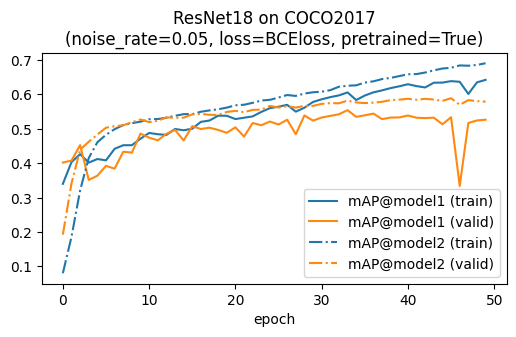

In [113]:
plt.figure(figsize=(6, 3))
plt.plot(meter_vanilla_train.values['mAP_q'], '-', color='#27a', label='mAP@model1 (train)')
plt.plot(meter_vanilla_valid.values['mAP_q'], '-', color='#f81', label='mAP@model1 (valid)')
plt.plot(meter_vanilla_train.values['mAP_k'], '-.', color='#27a', label='mAP@model2 (train)')
plt.plot(meter_vanilla_valid.values['mAP_k'], '-.', color='#f81', label='mAP@model2 (valid)')
plt.legend()
plt.xlabel('epoch')
plt.title('ResNet18 on COCO2017\n(noise_rate=0.05, loss=BCEloss, pretrained=True)')
plt.show()

### Parameter Transferring

In [115]:
torch.save(model_q.state_dict(), 'model_q_1114_warmup.pkl')
torch.save(model_k.state_dict(), 'model_k_1114_warmup.pkl')

In [30]:
model_q = PicoNet(dim_embedding=dim_embedding, num_classes=num_classes, pretrained=True).cuda()
model_k = PicoNet(dim_embedding=dim_embedding, num_classes=num_classes, pretrained=True).cuda()
model_q.load_state_dict(torch.load('model_q_1114_warmup.pkl'))
model_k.load_state_dict(torch.load('model_k_1114_warmup.pkl'))

/hdd/lzm/.conda/envs/multi-label/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/hdd/lzm/.conda/envs/multi-label/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [31]:
for param_q, param_k in zip(model_q.parameters(), model_k.parameters()):
    param_q.data.copy_(param_k.data)
    assert param_q.requires_grad == True

### Contrastive Training

In [32]:
meter_contrastive_train = LastMeter()
meter_contrastive_valid = LastMeter()
contrastive_epoch = 0

In [58]:
classific_weight = 0.0
contrastive_weight = 0.5 * 10
momentum_encoder = 0.1

In [61]:
for e in range(10):
    meter_epoch_train = train_epoch_contrastive(show_progress=True, update_target=False)
    meter_epoch_valid = eval_epoch_contrastive(show_progress=True)
    
    print(f'epoch {contrastive_epoch:>2d} (train): {meter_epoch_train}')
    print(f'epoch {contrastive_epoch:>2d} (valid): {meter_epoch_valid}')
    
    meter_contrastive_train.update(epoch=contrastive_epoch, **meter_epoch_train.average_value())
    meter_contrastive_valid.update(epoch=contrastive_epoch, **meter_epoch_valid.average_value())
    
    contrastive_epoch += 1

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

epoch 28 (train): loss_clf: 17.996, loss_con: 6.436, mAP_clf: 0.692, mAP_proto: 0.598, sim_proto: 0.607
epoch 28 (valid): conf_pseu: 1.000, acc_pseu: 0.433, mAP_clf: 0.578, mAP_proto: 0.513, sim_proto: 0.609


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

epoch 29 (train): loss_clf: 17.984, loss_con: 6.390, mAP_clf: 0.694, mAP_proto: 0.600, sim_proto: 0.616
epoch 29 (valid): conf_pseu: 1.000, acc_pseu: 0.433, mAP_clf: 0.580, mAP_proto: 0.514, sim_proto: 0.617


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

epoch 30 (train): loss_clf: 17.998, loss_con: 6.410, mAP_clf: 0.692, mAP_proto: 0.597, sim_proto: 0.611
epoch 30 (valid): conf_pseu: 1.000, acc_pseu: 0.433, mAP_clf: 0.577, mAP_proto: 0.515, sim_proto: 0.614


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

epoch 31 (train): loss_clf: 18.013, loss_con: 6.412, mAP_clf: 0.692, mAP_proto: 0.596, sim_proto: 0.612
epoch 31 (valid): conf_pseu: 1.000, acc_pseu: 0.433, mAP_clf: 0.578, mAP_proto: 0.511, sim_proto: 0.610


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

epoch 32 (train): loss_clf: 17.976, loss_con: 6.408, mAP_clf: 0.692, mAP_proto: 0.601, sim_proto: 0.614
epoch 32 (valid): conf_pseu: 1.000, acc_pseu: 0.433, mAP_clf: 0.577, mAP_proto: 0.520, sim_proto: 0.612


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

epoch 33 (train): loss_clf: 17.994, loss_con: 6.368, mAP_clf: 0.694, mAP_proto: 0.598, sim_proto: 0.615
epoch 33 (valid): conf_pseu: 1.000, acc_pseu: 0.433, mAP_clf: 0.579, mAP_proto: 0.511, sim_proto: 0.618


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

epoch 34 (train): loss_clf: 18.030, loss_con: 6.419, mAP_clf: 0.691, mAP_proto: 0.595, sim_proto: 0.612
epoch 34 (valid): conf_pseu: 1.000, acc_pseu: 0.433, mAP_clf: 0.574, mAP_proto: 0.512, sim_proto: 0.614


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

epoch 35 (train): loss_clf: 17.978, loss_con: 6.383, mAP_clf: 0.693, mAP_proto: 0.597, sim_proto: 0.614
epoch 35 (valid): conf_pseu: 1.000, acc_pseu: 0.433, mAP_clf: 0.576, mAP_proto: 0.513, sim_proto: 0.617


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

epoch 36 (train): loss_clf: 18.008, loss_con: 6.402, mAP_clf: 0.692, mAP_proto: 0.598, sim_proto: 0.615
epoch 36 (valid): conf_pseu: 1.000, acc_pseu: 0.433, mAP_clf: 0.575, mAP_proto: 0.507, sim_proto: 0.609


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

epoch 37 (train): loss_clf: 17.979, loss_con: 6.430, mAP_clf: 0.693, mAP_proto: 0.602, sim_proto: 0.615
epoch 37 (valid): conf_pseu: 1.000, acc_pseu: 0.433, mAP_clf: 0.580, mAP_proto: 0.517, sim_proto: 0.617


#### Result

In [63]:
import matplotlib.pyplot as plt

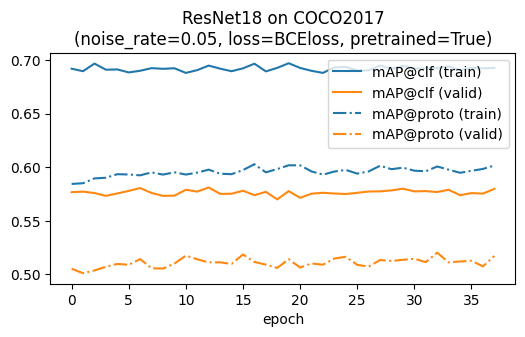

In [217]:
plt.figure(figsize=(6, 3))
plt.plot(meter_contrastive_train.values['mAP_clf'], '-', color='#27a', label='mAP@clf (train)')
plt.plot(meter_contrastive_valid.values['mAP_clf'], '-', color='#f81', label='mAP@clf (valid)')
plt.plot(meter_contrastive_train.values['mAP_proto'], '-.', color='#27a', label='mAP@proto (train)')
plt.plot(meter_contrastive_valid.values['mAP_proto'], '-.', color='#f81', label='mAP@proto (valid)')
plt.legend()
plt.xlabel('epoch')
plt.title('ResNet18 on COCO2017\n(noise_rate=0.05, loss=BCEloss, pretrained=True)')
plt.show()

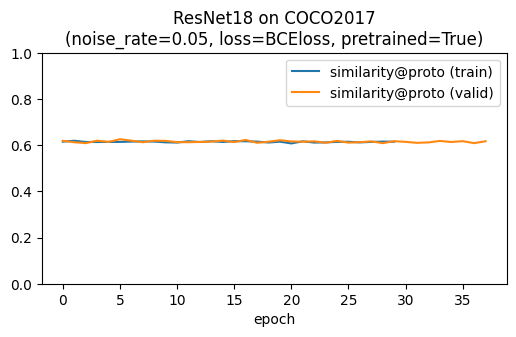

In [263]:
plt.figure(figsize=(6, 3))
plt.plot(meter_contrastive_train.values['sim_proto'], '-', color='#27a', label='similarity@proto (train)')
plt.plot(meter_contrastive_valid.values['sim_proto'], '-', color='#f81', label='similarity@proto (valid)')
plt.legend()
plt.xlabel('epoch')
plt.ylim(0, 1)
plt.title('ResNet18 on COCO2017\n(noise_rate=0.05, loss=BCEloss, pretrained=True)')
plt.show()

## Result

In [30]:
print(meter_train)
print(meter_valid)

NameError: name 'meter_train' is not defined

In [31]:
import matplotlib.pyplot as plt

In [32]:
plt.figure(figsize=(6, 3))
plt.plot(meter_train.values['mAP_q'], '-', color='#27a', label='mAP@model1 (train)')
plt.plot(meter_valid.values['mAP_q'], '-', color='#f81', label='mAP@model1 (valid)')
plt.plot(meter_train.values['mAP_k'], '-.', color='#27a', label='mAP@model2 (train)')
plt.plot(meter_valid.values['mAP_k'], '-.', color='#f81', label='mAP@model2 (valid)')
plt.legend()
plt.xlabel('epoch')
plt.title('TResNet-Large on COCO2017\n(noise_rate=0.05, loss=BCEloss, pretrained=True)')
plt.show()

NameError: name 'meter_train' is not defined

<Figure size 600x300 with 0 Axes>

`TResNet-Large on COCO2017 (noise_rate=0.05, loss=BCEloss, pretrained=True)`: 

得益于预训练参数, mAP 在30个epoch内迅速上升至0.66，随后过拟合。

`TResNet-Large on COCO2017 (noise_rate=0.05, loss=BCEloss, pretrained=False)`: 
 
mAP 在120个epoch左右时上升至0.50, 随后过拟合。

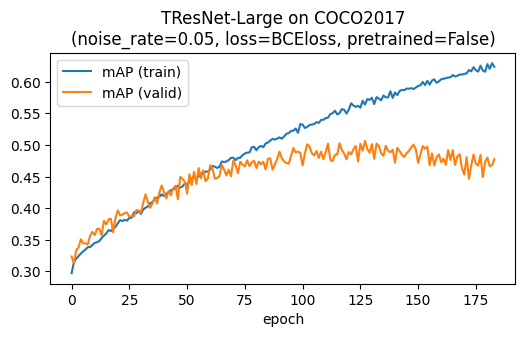

In [44]:
plt.figure(figsize=(6, 3))
plt.plot(meter_train.values['mAP'], label='mAP (train)')
plt.plot(meter_valid.values['mAP'], label='mAP (valid)')
plt.legend()
plt.xlabel('epoch')
plt.title('TResNet-Large on COCO2017\n(noise_rate=0.05, loss=BCEloss, pretrained=False)')
plt.show()

## Debug

### Train

In [218]:
model_q.train()
model_k.train()

it = iter(train_loader)

In [219]:
indices, img, img_w, img_s, y_true, y_candidate = next(it)

img_w, img_s = img_w.cuda(), img_s.cuda()
y_candidate, y_true = y_candidate.cuda(), y_true.cuda()
indices = indices.cuda()
batch_size, num_classes = y_candidate.shape

#### Vanilla

In [46]:
_, y_logit_q = model_q(img_w)
_, y_logit_k = model_k(img_w)
y_score_q = sigmoid(y_logit_q)
y_score_k = sigmoid(y_logit_k)

with torch.no_grad():
    for param_q, param_k in zip(model_q.parameters(), model_k.parameters()):
        param_k.data += momentum_encoder * (param_q.data - param_k.data)

loss = multilabel_partial_loss(y_target=y_candidate, y_score=y_score_q)

# optimize
# optimizer.zero_grad()
# loss.backward()
# optimizer.step()

# record
loss_clf = loss.item()
r_loss_q = label_ranking_loss(y_true, y_score_q)
mAP_q = average_precision_score(y_true, y_score_q)
r_loss_k = label_ranking_loss(y_true, y_score_k)
mAP_k = average_precision_score(y_true, y_score_k)

In [47]:
y_score_q

tensor([[0.0301, 0.0190, 0.0064,  ..., 0.1537, 0.0295, 0.0282],
        [0.9953, 0.0317, 0.0441,  ..., 0.0200, 0.0297, 0.0759],
        [0.9978, 0.0613, 0.0697,  ..., 0.0168, 0.0386, 0.0392],
        ...,
        [0.9532, 0.3188, 0.9491,  ..., 0.0492, 0.0145, 0.0332],
        [0.2229, 0.0971, 0.0255,  ..., 0.1158, 0.0587, 0.1355],
        [0.9960, 0.0314, 0.0411,  ..., 0.0277, 0.0312, 0.0564]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)

In [46]:
y_candidate.sum(dim=1).mean()

tensor(5.8750, device='cuda:0')

#### Contrastive

In [220]:
update_target = False
classific_weight = 0.0
contrastive_weight = 1.0

In [221]:
embed_q, y_logit_q = model_q(img_w)
embed_k, _         = model_k(img_s) # no_grad

y_score_q = sigmoid(y_logit_q)

y_score_p_pos = 0.5 + 0.5 * embed_q @ embed_p_pos.t() # (0, 1)
y_score_p_neg = 0.5 + 0.5 * embed_q @ embed_p_neg.t() # (0, 1)
y_score_p = y_score_p_pos / (y_score_p_pos + y_score_p_neg)

y_target_q = (y_score_q > 0.5).float().detach() * y_candidate # no_grad
y_target_p = (y_score_p > 0.5).float().detach() * y_candidate # no_grad

# momentum update
with torch.no_grad():
    # momentum update embed_p_pos, embed_p_neg
    for tgt, emd_q in zip(y_target_q, embed_q):
        embed_p_pos += momentum_proto * (emd_q.unsqueeze(0) - embed_p_pos) * tgt.unsqueeze(-1)
        embed_p_neg += momentum_proto * (emd_q.unsqueeze(0) - embed_p_neg) * (1.0 - tgt).unsqueeze(-1)
    embed_p_pos = normalize(embed_p_pos, p=2, dim=1)
    embed_p_neg = normalize(embed_p_neg, p=2, dim=1)

    # momentum update Y_cls_target
    if update_target:
        Y_cls_target[indices] += momentum_target * (y_target_p - Y_cls_target[indices])

    # update queue
    embed_k_queue[queue_idx: queue_idx + batch_size] = embed_k
    y_target_q_queue[queue_idx: queue_idx + batch_size] = y_target_q
    queue_idx = (queue_idx + batch_size) % queue_size

# make contrastive pairs
with torch.no_grad():
    keys = torch.cat([embed_q, embed_k_queue], dim=0)
    targets = torch.cat([y_target_q, y_target_q_queue], dim=0)
    mask = (torch.cdist(y_target_q, targets) < 0.1).float()
    # mask-out self-contrast cases
    mask *= (1.0 - torch.eye(*mask.shape).to(mask.device))

loss_classific = multilabel_partial_loss(y_target=Y_cls_target[indices], y_score=y_score_q)
loss_contrastive = info_nce_loss2(query=embed_q, keys=keys, positive_mask=mask)
# auxiliary loss
loss_prototype = 0.0

loss = classific_weight * loss_classific + contrastive_weight * loss_contrastive

# optimize
# optimizer.zero_grad()
# loss.backward()
# optimizer.step()

with torch.no_grad():
    # momentum update encoder_k
    for param_q, param_k in zip(model_q.parameters(), model_k.parameters()):
        param_k.data += momentum_encoder * (param_q.data - param_k.data)


In [225]:
embed_q, y_logit_q = model_q(img_w)
embed_k, _         = model_k(img_s) # no_grad

y_score_q = sigmoid(y_logit_q)
y_target_q = (y_score_q > 0.5).float().detach()

y_score_p_pos = 0.5 + 0.5 * embed_q @ embed_p_pos.t()
y_score_p_neg = 0.5 + 0.5 * embed_q @ embed_p_neg.t()
y_score_p = y_score_p_pos / (y_score_p_pos + y_score_p_neg)

with torch.no_grad():
    keys = torch.cat([embed_q, embed_k_queue], dim=0)
    targets = torch.cat([y_target_q, y_target_q_queue], dim=0)
    mask = (torch.cdist(y_target_q, targets) < 0.1).float()
    proto_similarity = ((embed_q @ keys.t()) * mask).sum() / mask.sum()

In [226]:
proto_similarity

tensor(0.6179, device='cuda:0')

In [227]:
embed_q

tensor([[-0.0568,  0.0525, -0.0505,  ...,  0.0113,  0.0341,  0.1487],
        [ 0.1333, -0.0556,  0.0444,  ..., -0.0320,  0.0275,  0.0273],
        [-0.1028,  0.0761,  0.0371,  ...,  0.0295,  0.0260,  0.0003],
        ...,
        [ 0.0940, -0.0637,  0.0024,  ...,  0.0850, -0.0271,  0.0315],
        [-0.0428, -0.0532,  0.0038,  ..., -0.0498,  0.0651, -0.0184],
        [-0.0858, -0.0082,  0.0046,  ...,  0.0169, -0.0014,  0.0458]],
       device='cuda:0', grad_fn=<DivBackward0>)

In [228]:
embed_k

tensor([[-0.0338, -0.0263, -0.0502,  ..., -0.0425,  0.0758,  0.0232],
        [ 0.0017, -0.0507,  0.0156,  ...,  0.0438,  0.0571,  0.0472],
        [-0.1029,  0.1173,  0.0445,  ...,  0.0076,  0.0057, -0.0320],
        ...,
        [ 0.0973, -0.0118,  0.0205,  ...,  0.0614,  0.0271,  0.0497],
        [-0.0717, -0.0335, -0.0733,  ...,  0.0230,  0.0584, -0.0298],
        [-0.0457, -0.0004,  0.0242,  ..., -0.0112,  0.0333,  0.1266]],
       device='cuda:0', grad_fn=<DivBackward0>)

In [204]:
torch.tens

0.7089201807975769

In [206]:
pseudo_label_accuracy((y_score_p > 0.5).float(), y_candidate, y_true)

0.7323943376541138

In [184]:
sharpen(y_score_p, t=0.5) 

tensor([[0.9360, 0.0640, 0.7049,  ..., 0.6892, 0.0640, 0.0640],
        [0.8817, 0.0691, 0.6923,  ..., 0.6708, 0.0691, 0.0691],
        [0.8756, 0.0698, 0.8714,  ..., 0.6466, 0.0698, 0.0698],
        ...,
        [0.9329, 0.0671, 0.6427,  ..., 0.7017, 0.0671, 0.0671],
        [0.9346, 0.0654, 0.7571,  ..., 0.6154, 0.0654, 0.0654],
        [0.7997, 0.0652, 0.6574,  ..., 0.6594, 0.0652, 0.0652]],
       device='cuda:0', grad_fn=<DivBackward0>)

In [173]:
sharpen(y_score_p, t=0.2, eps=0.01).min(dim=1).values

tensor([0.2012, 0.2124, 0.2193, 0.2136, 0.1947, 0.2114, 0.1935, 0.1971, 0.2102,
        0.2036, 0.1888, 0.2030, 0.2308, 0.2042, 0.2117, 0.1866, 0.1741, 0.2071,
        0.1856, 0.2235, 0.1998, 0.1905, 0.2126, 0.2094, 0.1727, 0.2031, 0.2251,
        0.2058, 0.2166, 0.2063, 0.2004, 0.2006], device='cuda:0',
       grad_fn=<MinBackward0>)

In [90]:
multilabel_partial_loss(Y_cls_target[indices], Y_cls_target[indices])

tensor(3.2766, device='cuda:0')

In [86]:
# optimize
optimizer.zero_grad()
loss.backward()
optimizer.step()

In [78]:
y_score_q

AttributeError: 'Tensor' object has no attribute 'retrain_grad'

In [44]:
y_candidate.sum(dim=1).mean()

tensor(6.5000, device='cuda:0')

In [45]:
y_true.sum(dim=1).mean()

tensor(2.7188, device='cuda:0')

### Eval

### Visualize

In [229]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean=mean
        self.std=std
 
    def __call__(self, tensor):
        tensor = tensor.clone()
        for t, m, s in zip(tensor,self.mean,self.std):
            t.mul_(s).add_(m)
        return tensor

In [230]:
t = transforms.Compose([
    UnNormalize((0.2443, 0.2394, 0.2425), (0.2443, 0.2394, 0.2425)),
    transforms.ToPILImage()
])

In [248]:
index, image_basic, image_weak_aug, image_strong_aug, y_true, y_candidate = dataset[0]

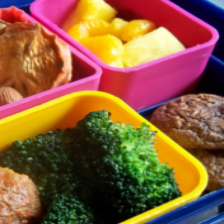

In [252]:
t(image_basic)

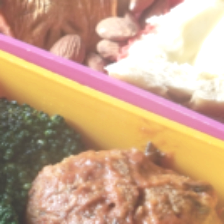

In [253]:
t(image_weak_aug)

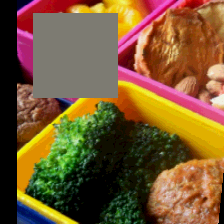

In [254]:
t(image_strong_aug)

In [216]:
for i in range(20):
    embed_n = normalize(embed, dim=1)
    loss = info_nce_loss2(embed_n, embed_n.detach(), mask)
    opt.zero_grad()
    loss.backward()
    opt.step()

    proto_similarity = ((embed_n.detach() @ embed_n.detach().t()) * mask).sum() / mask.sum()

    print(f'{loss = :.2f}')
    print(f'{proto_similarity = :.2f}')
    print(f'{embed_n = }')

loss = 0.98
proto_similarity = 0.99
embed_n = tensor([[-0.4835, -0.4077, -0.6626, -0.4012],
        [-0.4213, -0.4291, -0.7145, -0.3576],
        [ 0.3663, -0.8766, -0.1930,  0.2452],
        [ 0.4337, -0.8300, -0.2583,  0.2371],
        [ 0.2790, -0.8808, -0.3227,  0.2054]], grad_fn=<DivBackward0>)
loss = 0.97
proto_similarity = 0.99
embed_n = tensor([[-0.4750, -0.4121, -0.6699, -0.3947],
        [-0.4256, -0.4271, -0.7114, -0.3610],
        [ 0.3639, -0.8786, -0.1875,  0.2461],
        [ 0.4222, -0.8341, -0.2672,  0.2337],
        [ 0.2934, -0.8776, -0.3161,  0.2094]], grad_fn=<DivBackward0>)
loss = 0.96
proto_similarity = 0.99
embed_n = tensor([[-0.4672, -0.4160, -0.6765, -0.3887],
        [-0.4295, -0.4252, -0.7087, -0.3641],
        [ 0.3617, -0.8802, -0.1830,  0.2468],
        [ 0.4118, -0.8376, -0.2751,  0.2306],
        [ 0.3062, -0.8745, -0.3101,  0.2129]], grad_fn=<DivBackward0>)
loss = 0.96
proto_similarity = 0.99
embed_n = tensor([[-0.4602, -0.4194, -0.6822, -0.3833],
     

In [133]:
loss = info_nce_loss2(embed, embed.detach(), mask)
loss.backward()
loss, embed

(tensor(70.8871, grad_fn=<MeanBackward0>),
 tensor([[-1.4739, -2.6968,  0.8080,  0.3447],
         [-0.7184, -0.2932,  0.8868,  1.5152],
         [-1.2408, -0.2073, -1.6142,  0.0094],
         [-0.2891,  0.3038,  1.8483, -0.2331],
         [ 0.2469,  0.7139, -1.2068, -1.0379]], requires_grad=True))

tensor([[-1.3966, -0.7540,  2.1217,  1.5233],
        [ 0.8330,  0.2043, -0.3376, -0.2949],
        [-0.4667,  0.4979, -1.3720, -0.4096],
        [ 1.6738,  0.0546, -0.6103, -1.4591],
        [ 1.0413,  0.8975,  0.1344, -0.5790]], requires_grad=True)